In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ls.config.loader import load_config
import pandas as pd
import os
import numpy as np

#### Load configuration file

In [3]:
cfg = load_config("../configs/config.yaml")

In [4]:
df = pd.read_csv(os.path.join(cfg.dataset.data_folder, "icbhi_metadata.csv"))

#### Create columns for 4-class and 2-class problems and cycle duraitons

In [5]:
df['label_4c'] = df.apply(lambda r: 
    'Crackle' if r.Crackles==1 and r.Wheezes==0 else
    'Wheeze'  if r.Crackles==0 and r.Wheezes==1 else
    'Both'    if r.Crackles==1 and r.Wheezes==1 else
    'Normal', axis=1)

In [6]:
df["label_2c"] = np.where((df["Crackles"] + df["Wheezes"]) > 0, "Abnormal", "Normal")
df['CycleDur'] = df['CycleEnd'] - df['CycleStart']

df.head()

,PID,Filename,CycleIndex,CycleStart,CycleEnd,Crackles,Wheezes,Split,Device,Fold,Age,Sex,BMI,CW,CH,Disease,AuscLoc,label_4c,label_2c,CycleDur
0,101,101_1b1_Al_sc_Meditron,0,0.036,0.579,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,0.543
1,101,101_1b1_Al_sc_Meditron,1,0.579,2.450,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.871
2,101,101_1b1_Al_sc_Meditron,2,2.450,3.893,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.443
3,101,101_1b1_Al_sc_Meditron,3,3.893,5.793,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.900
4,101,101_1b1_Al_sc_Meditron,4,5.793,7.521,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.728


# Metadata Dataset Exploitation, Descriptive Statistics & Statistical Analysis

### Patients and recordings Information

In [7]:
# Filter data to ensure only PIDs with multiple cycles are used (which is all of them here)
print(f"Total unique patients (PIDs): {df['PID'].nunique()}")
pids_counts = df['PID'].value_counts()
valid_pids = pids_counts[pids_counts > 1].index
if len(valid_pids) < df['PID'].nunique():
    df = df[df['PID'].isin(valid_pids)]
    print(f"Filtered to PIDs with multiple cycles. New total unique PIDs: {df['PID'].nunique()}")
print(f"Total unique recordings: {df['Filename'].nunique()}")
print(f"Total cycles analyzed: {len(df)}")

print(f"Each patient contributes an average of {df.groupby('Filename').size().mean():.2f} lung sound recordings, " \
      f"and an average of {df.groupby('PID').size().mean():.2f} cycles."
)

Total unique patients (PIDs): 126
Total unique recordings: 920
Total cycles analyzed: 6898
Each patient contributes an average of 7.50 lung sound recordings, and an average of 54.75 cycles.


### Check for patient leakage/overlap between train and test sets

In [8]:
# Basic integrity checks
assert df["PID"].nunique() == df.groupby("PID")["Split"].nunique().max(), "A PID appears in both splits!"

AssertionError: A PID appears in both splits!

In [9]:
dup_pids = (
    df.groupby("PID")["Split"]
      .nunique()
      .reset_index()
      .query("Split > 1")
)

if not dup_pids.empty:
    print("Patients appearing in both training and test splits:")
    display(df[df["PID"].isin(dup_pids["PID"])][["PID","Filename", "Split"]].drop_duplicates())

Patients appearing in both training and test splits:


,PID,Filename,Split
2896,156,156_2b3_Al_mc_AKGC417L,test
2902,156,156_2b3_Ar_mc_AKGC417L,train
2908,156,156_2b3_Ll_mc_AKGC417L,train
2914,156,156_2b3_Lr_mc_AKGC417L,test
2920,156,156_2b3_Pl_mc_AKGC417L,test
2926,156,156_2b3_Pr_mc_AKGC417L,train
2932,156,156_5b3_Al_mc_AKGC417L,train
2941,156,156_5b3_Ar_mc_AKGC417L,test
2950,156,156_5b3_Ll_mc_AKGC417L,test
2959,156,156_5b3_Lr_mc_AKGC417L,train


In [10]:
assert (df["CycleDur"] > 0).all(), "Non-positive cycle duration found"

In [11]:
def print_section(title, df):
    print("\n" + "="*80)
    print(f"{title.upper()}")
    print("="*80)
    print(df.to_string())
    print()

### Class imbalances Calculation or the official fixed train/test split (2-class & 4-class problem)

### Global Dataset (Train + Test)

In [12]:
print_section("4-Class Global Counts", df["label_4c"].value_counts().to_frame("count"))
print_section("4-Class Global Proportions", df["label_4c"].value_counts(normalize=True).round(3).to_frame("proportion"))

print_section("2-Class Global Counts", df["label_2c"].value_counts().to_frame("count"))
print_section("2-Class Global Proportions", df["label_2c"].value_counts(normalize=True).round(3).to_frame("proportion"))


4-CLASS GLOBAL COUNTS
          count
label_4c       
Normal     3642
Crackle    1864
Wheeze      886
Both        506


4-CLASS GLOBAL PROPORTIONS
          proportion
label_4c            
Normal         0.528
Crackle        0.270
Wheeze         0.128
Both           0.073


2-CLASS GLOBAL COUNTS
          count
label_2c       
Normal     3642
Abnormal   3256


2-CLASS GLOBAL PROPORTIONS
          proportion
label_2c            
Normal         0.528
Abnormal       0.472



### Class imbalances for each split (4-class problem)

In [13]:
# By split
by_split_4c = df.pivot_table(index="Split", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
by_split_prop_4c = by_split_4c.div(by_split_4c.sum(axis=1), axis=0).round(3)
print_section("4-Class Counts by Split", by_split_4c)
print_section("4-Class Proportions by Split", by_split_prop_4c)
# print("\n4c counts by Split:\n", by_split)
# print("\n4c proportions by Split:\n", by_split_prop)


4-CLASS COUNTS BY SPLIT
label_4c  Both  Crackle  Normal  Wheeze
Split                                  
test       143      649    1579     385
train      363     1215    2063     501


4-CLASS PROPORTIONS BY SPLIT
label_4c   Both  Crackle  Normal  Wheeze
Split                                   
test      0.052    0.235   0.573   0.140
train     0.088    0.293   0.498   0.121



### Class imbalances for each split (2-class problem)

In [14]:
# By split
by_split = df.pivot_table(index="Split", columns="label_2c", values="Filename", aggfunc="count").fillna(0).astype(int)
by_split_prop = by_split.div(by_split.sum(axis=1), axis=0).round(3)
print_section("2-Class Counts by Split", by_split)
print_section("2-Class Proportions by Split", by_split_prop)


2-CLASS COUNTS BY SPLIT
label_2c  Abnormal  Normal
Split                     
test          1177    1579
train         2079    2063


2-CLASS PROPORTIONS BY SPLIT
label_2c  Abnormal  Normal
Split                     
test         0.427   0.573
train        0.502   0.498



### Findings:

* Global 4-class: Normal 52.8%, Crackle 27.0%, Wheeze 12.8%, Both 7.3%.
* 2-class: Normal 52.8% vs Abnormal 47.2% → close to balanced.

Train–test label mix isn’t identical

* Test has more Normal (57.3%) and fewer Crackle (23.5%) & Both (5.2%) than Train (Normal 49.8%, Crackle 29.3%, Both 8.8%).   
 -> Expect lower sensitivity on test (especially for Crackle/Both) if you tune on train-like prevalence.

### Descriptive statistics for the breathing cycle duraiton for the 4-class problem

(0.0, 6.4110000000000005)

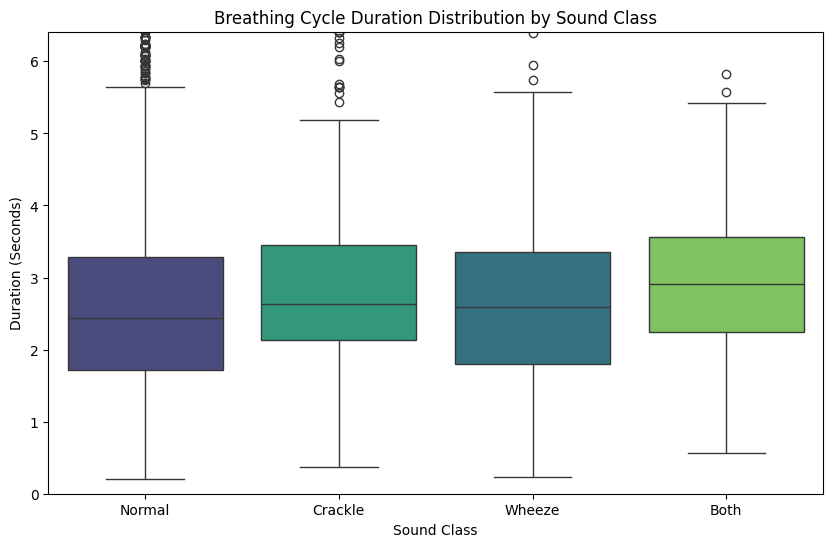

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='label_4c', y='CycleDur', data=df,
            order=['Normal', 'Crackle', 'Wheeze', 'Both'],
            hue='label_4c',
            palette='viridis',
            # showfliers=False
    )
plt.title('Breathing Cycle Duration Distribution by Sound Class')
plt.xlabel('Sound Class')
plt.ylabel('Duration (Seconds)')
plt.ylim(0, df['CycleDur'].quantile(0.99)) # Limit y-axis for better readability
# plt.savefig('duration_boxplot.png')
# print("Box plot saved as 'duration_boxplot.png'")

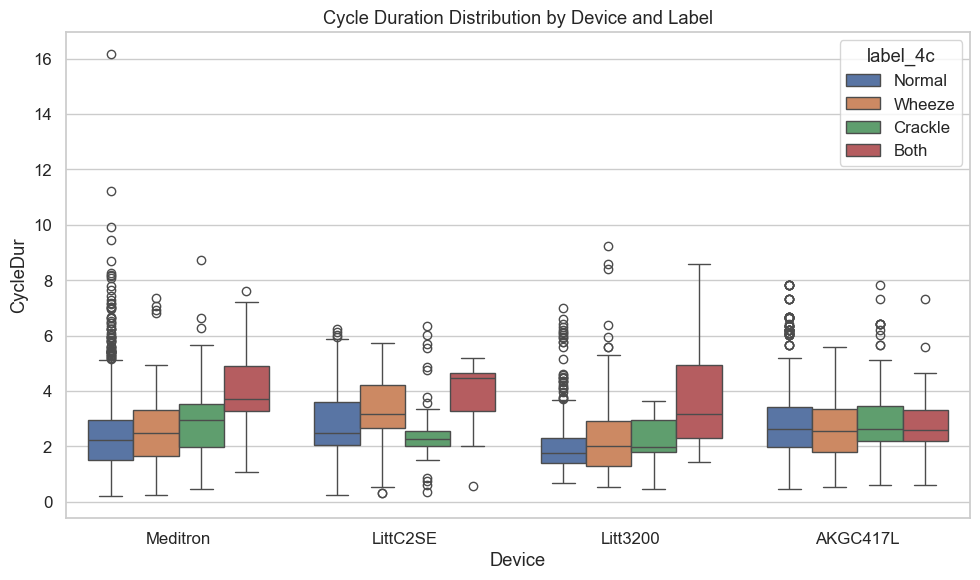

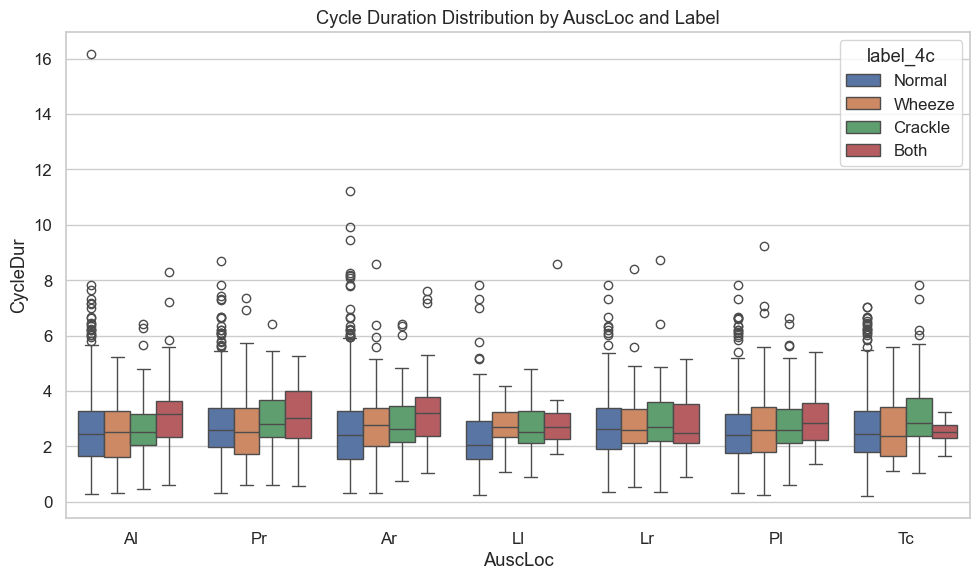

In [78]:
# Duration patterns per Device / Site / Label
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Device", y="CycleDur", hue="label_4c")
plt.title("Cycle Duration Distribution by Device and Label")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="AuscLoc", y="CycleDur", hue="label_4c")
plt.title("Cycle Duration Distribution by AuscLoc and Label")
plt.tight_layout()
plt.show()

In [18]:
dur_stats = df.groupby("label_4c")["CycleDur"].describe().round(3)
# print("\nCycle duration stats (sec) by 4c:\n", dur_stats)

# per-split duration sanity
dur_split = df.groupby(["Split","label_4c"])["CycleDur"].describe().round(3)
# print("\nCycle duration stats by Split × 4c:\n", dur_split)

print_section("Cycle Duration Stats (sec) by 4-Class Label", dur_stats)
print_section("Cycle Duration Stats (sec) by Split × Label", dur_split)


CYCLE DURATION STATS (SEC) BY 4-CLASS LABEL
           count   mean    std    min    25%    50%    75%     max
label_4c                                                          
Both       506.0  3.060  1.092  0.571  2.238  2.904  3.558   8.592
Crackle   1864.0  2.785  0.952  0.367  2.137  2.629  3.449   8.736
Normal    3642.0  2.607  1.275  0.200  1.716  2.443  3.288  16.163
Wheeze     886.0  2.703  1.143  0.228  1.803  2.584  3.357   9.217


CYCLE DURATION STATS (SEC) BY SPLIT × LABEL
                 count   mean    std    min    25%    50%    75%     max
Split label_4c                                                          
test  Both       143.0  3.358  1.316  1.057  2.277  3.233  4.007   8.592
      Crackle    649.0  3.093  0.923  0.443  2.605  3.212  3.773   6.411
      Normal    1579.0  2.391  1.037  0.286  1.564  2.310  3.141   7.632
      Wheeze     385.0  2.668  1.259  0.228  1.583  2.512  3.456   9.217
train Both       363.0  2.942  0.967  0.571  2.238  2.734  3.417   7.

## Do breathing cycle durations differ between sound classes?

H₀:

Cycle duration distributions are identical across Normal, Crackle, Wheeze, and Both.

H₁:

At least one label’s duration distribution differs.

**Goal:**  
We want to test whether **breathing cycle duration** differs significantly between sound classes (`normal`, `crackle`, `wheeze`, `both`)

### Rationale
Cycles are *nested within patients*, so samples are **not independent**. We therefore use two complementary, statistically approaches:

1. **Paired non-parametric tests on per-patient means**  
   - Compute per-patient mean `CycleDur` for each class -> a *within-subject* design  
   - For each pair of classes, run **Wilcoxon signed-rank** test (paired) on patients who have both classes  
   - Multiple-testing correction (Holm/Bonferroni)

2. **Linear Mixed-Effects Model (LMM)**  
   - Model: `CycleDur ~ C(label_4c) + (1 | PID)`  
   - Refit the LMM cycling the **reference class** to recover **all pairwise** comparisons directly from model coefficients  
   - Multiple-testing correction across all pairs

In [19]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import wilcoxon
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

In [ ]:

group_names = df["label_4c"].unique().tolist()

# Pivot to patient × class table of means
df_pmeans = (
    df.groupby(["PID", "label_4c"])["CycleDur"]
      .mean()
      .unstack()
)
display(df_pmeans.head())
    
def wilcoxon_all_pairs(df_pmeans, labels, correction="holm"): # 'holm' is slightly less conservative than Bonferroni
    """
    Run paired Wilcoxon on per-patient means for all class pairs.
    Only patients with both classes present are used per comparison.
    Returns a summary DataFrame with multiple-testing correction.
    """
    rows = []
    for a, b in itertools.combinations(labels, 2):

        pair_df = df_pmeans[[a, b]].dropna()
        n = len(pair_df)
        if n < 5:
            rows.append({"pair": f"{a} vs {b}", "n": n, "W": np.nan, "p_raw": np.nan,
                         "note": "insufficient paired patients"})
            continue
        stat, p = wilcoxon(pair_df[a], pair_df[b], zero_method="wilcox", alternative="two-sided")
        rows.append({"pair": f"{a} vs {b}", "n": n, "W": stat, "p_raw": p, "note": ""})
    out = pd.DataFrame(rows)
    if out.empty:
        return out
    # Multiple testing correction
    mask = out["p_raw"].notna()
    if mask.any():
        reject, p_corr, _, _ = multipletests(out.loc[mask, "p_raw"], method=correction)
        out.loc[mask, "p_corr"] = p_corr
        out.loc[mask, "reject@0.05"] = reject
    else:
        out["p_corr"] = np.nan
        out["reject@0.05"] = False
    return out.sort_values("p_corr")

wilcox_df = wilcoxon_all_pairs(df_pmeans, group_names, correction="bonferroni")
print("\n=== Paired Wilcoxon on per-patient means ===")
display(wilcox_df)

label_4c,Both,Crackle,Normal,Wheeze
PID,,,,
101,NaN,NaN,1.731652,NaN
102,NaN,NaN,1.515385,NaN
103,NaN,NaN,3.186000,3.31075
104,NaN,1.5673,2.196492,1.90480
105,NaN,NaN,2.483875,NaN



=== Paired Wilcoxon on per-patient means ===


,pair,n,W,p_raw,note,p_corr,reject@0.05
2,Normal vs Both,34,102.0,0.000501,,0.003009,True
1,Normal vs Crackle,72,814.0,0.005018,,0.030111,True
4,Wheeze vs Both,34,148.0,0.009574,,0.057445,False
0,Normal vs Wheeze,62,657.0,0.025088,,0.150531,False
5,Crackle vs Both,30,164.0,0.164184,,0.985104,False
3,Wheeze vs Crackle,45,475.0,0.815448,,1.000000,False


### Linear Mixed-Effects Model & Pairwise Comparisons

Now that we know our samples are *not independent* (multiple cycles per patient),  
we use a **Linear Mixed-Effects Model (LMM)** to formally test:


$\text{CycleDur} = \beta_0 + \beta_{\text{class}} + u_{\text{PID}} + \epsilon$

where:
- **fixed effect:** sound class (`label_4c`)  
- **random effect:** patient intercept (`PID`)

After fitting, we compute **pairwise contrasts** between classes to see *which pairs* differ significantly.

In [21]:
# Mixed-Effects Model (confirmatory, all pairwise)
def fit_lmm_with_reference(reference_label: str):
    """
    Fits a mixed-effects model with a given reference label.
    Returns the fitted result, total SD, and variance components.
    """
    formula = f"CycleDur ~ C(label_4c, Treatment(reference='{reference_label}'))"
    model = smf.mixedlm(formula, data=df, groups=df["PID"])
    res = model.fit(method="lbfgs", reml=True)
    # variance components
    var_re = float(res.cov_re.iloc[0, 0])       # random intercept variance
    var_resid = float(res.scale)                # residual variance
    sd_total = np.sqrt(var_re + var_resid)      # total SD for standardization
    return res, sd_total, var_re, var_resid

# Fit LMM per reference and extract pairwise comparisons
lmm_rows = []
for ref in group_names:
    res, sd_total, var_re, var_resid = fit_lmm_with_reference(ref)
    params, pvals, tvals = res.params, res.pvalues, res.tvalues
    df_resid = res.df_resid
    for other in group_names:
        if other == ref:
            continue
        term = f"C(label_4c, Treatment(reference='{ref}'))[T.{other}]"
        if term in params.index:
            est = float(params[term])
            p = float(pvals[term])
            t = float(tvals[term])
            # Effect sizes
            d_mixed = est / sd_total
            partial_r2 = (t**2) / (t**2 + df_resid)
            lmm_rows.append({
                "pair": f"{ref} vs {other}",                # mean(other) - mean(ref)
                "est_diff_s": est,
                "p_raw": p,
                "t_value": t,
                "Cohen_d_mixed": d_mixed,
                "partial_R2": partial_r2,
                "ref": ref,
                "var_re": var_re,
                "var_resid": var_resid,
                "sd_total": sd_total
            })

# Deduplicate unordered pairs (keep smallest p-value)
def canon_pair(pair_str):
    a, _, b = pair_str.partition(" vs ")
    return " vs ".join(sorted([a.strip(), b.strip()]))

lmm_df = pd.DataFrame(lmm_rows)
if not lmm_df.empty:
    lmm_df["canon"] = lmm_df["pair"].apply(canon_pair)
    lmm_df = lmm_df.sort_values("p_raw").drop_duplicates("canon", keep="first")
    lmm_df = lmm_df.drop(columns=["canon"]).reset_index(drop=True)
    # Multiple testing correction (Bonferroni)
    reject, p_corr, _, _ = multipletests(lmm_df["p_raw"], method="bonferroni")
    lmm_df["p_corr"] = p_corr
    lmm_df["reject@0.05"] = reject

print("\n=== Mixed-Effects Model (pairwise via rotating reference, with effect sizes) ===")
if lmm_df.empty:
    print("No pairwise results available.")
else:
    display(lmm_df.sort_values("p_corr"))

# Interpretation summary
print("\n--- Interpretation (LMM + effect sizes) ---")
if lmm_df.empty:
    print("No LMM results to interpret.")
else:
    for _, r in lmm_df.sort_values("p_corr").iterrows():
        strength = (
            "small" if abs(r["Cohen_d_mixed"]) < 0.3 else
            "medium" if abs(r["Cohen_d_mixed"]) < 0.6 else
            "large"
        )
        direction = "longer" if r["est_diff_s"] > 0 else "shorter"
        sig_text = "✅ significant" if r["reject@0.05"] else "⚠️ non-significant"
        print(
            f"• {r['pair']}: Δ={r['est_diff_s']:.3f}s ({direction}), "
            f"d={r['Cohen_d_mixed']:.2f} ({strength}), partial R²={r['partial_R2']:.3f}, "
            f"p_adj={r['p_corr']:.4f} → {sig_text}"
        )

# model-level R² for the last fitted model
if not lmm_df.empty:
    var_fix = np.var(res.fittedvalues)
    r2_marginal = var_fix / (var_fix + var_re + var_resid)
    r2_conditional = (var_fix + var_re) / (var_fix + var_re + var_resid)
    print(f"\nModel-level R² for last reference ({ref}):")
    print(f"  Marginal R² (fixed effects only): {r2_marginal:.3f}")
    print(f"  Conditional R² (fixed + random):  {r2_conditional:.3f}")


=== Mixed-Effects Model (pairwise via rotating reference, with effect sizes) ===


,pair,est_diff_s,p_raw,t_value,Cohen_d_mixed,partial_R2,ref,var_re,var_resid,sd_total,p_corr,reject@0.05
0,Both vs Normal,-0.435563,2.858398e-18,-8.716933,-0.344822,0.010902,Both,0.842249,0.753302,1.263151,1.715039e-17,True
1,Both vs Crackle,-0.354659,1.401045e-12,-7.083948,-0.280774,0.007227,Both,0.842249,0.753302,1.263151,8.406271e-12,True
2,Both vs Wheeze,-0.259436,1.324108e-06,-4.836101,-0.205388,0.003381,Both,0.842249,0.753302,1.263151,7.944649e-06,True
3,Normal vs Wheeze,0.176127,3.308171e-06,4.650696,0.139435,0.003128,Normal,0.842249,0.753302,1.263151,1.984903e-05,True
4,Normal vs Crackle,0.080903,7.178123e-03,2.688466,0.064049,0.001047,Normal,0.842249,0.753302,1.263151,4.306874e-02,True
5,Crackle vs Wheeze,0.095224,2.088551e-02,2.310048,0.075386,0.000773,Crackle,0.842249,0.753302,1.263151,1.253131e-01,False



--- Interpretation (LMM + effect sizes) ---
• Both vs Normal: Δ=-0.436s (shorter), d=-0.34 (medium), partial R²=0.011, p_adj=0.0000 → ✅ significant
• Both vs Crackle: Δ=-0.355s (shorter), d=-0.28 (small), partial R²=0.007, p_adj=0.0000 → ✅ significant
• Both vs Wheeze: Δ=-0.259s (shorter), d=-0.21 (small), partial R²=0.003, p_adj=0.0000 → ✅ significant
• Normal vs Wheeze: Δ=0.176s (longer), d=0.14 (small), partial R²=0.003, p_adj=0.0000 → ✅ significant
• Normal vs Crackle: Δ=0.081s (longer), d=0.06 (small), partial R²=0.001, p_adj=0.0431 → ✅ significant
• Crackle vs Wheeze: Δ=0.095s (longer), d=0.08 (small), partial R²=0.001, p_adj=0.1253 → ⚠️ non-significant

Model-level R² for last reference (Both):
  Marginal R² (fixed effects only): 0.276
  Conditional R² (fixed + random):  0.658


**Interpretation:**

Breathing cycle duration increases progressively across sound categories:

$\textbf{Normal < Crackle <= Wheeze < Both}$

- Cycles labeled **Both** (containing both crackles and wheezes) are the **longest** on average.  
- **Normal** cycles are the **shortest**, showing significantly lower duration than all adventitious sound categories.  
- The **Crackle–Wheeze** difference is small and not statistically significant.  
- Most pairwise effects are statistically robust (*p* < 0.05 after Bonferroni correction) with **small-to-medium effect sizes** (|d| ≈ 0.1–0.35).

**Conclusion:**

The presence and complexity of adventitious sounds are associated with **progressively longer breathing cycles**, possibly reflecting airflow obstruction, prolonged expiration, or altered breathing mechanics.  
While statistically robust, these effects are **moderate in magnitude**, suggesting that duration captures a consistent physiological trend but should be interpreted as a **complementary descriptive feature** rather than a strong discriminator on its own.

### Digital Stethoscope Device Analysis

In [23]:
# Device × label
dev_tab = df.pivot_table(index="Device", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
dev_prop = dev_tab.div(dev_tab.sum(axis=1), axis=0).round(3)
# print("\nDevice × 4c counts:\n", dev_tab)
# print("\nDevice × 4c proportions:\n", dev_prop)
print_section("Device × Label Counts", dev_tab)
print_section("Device × Label Proportions", dev_prop)


DEVICE × LABEL COUNTS
label_4c  Both  Crackle  Normal  Wheeze
Device                                 
AKGC417L   381     1543    1922     500
Litt3200    25       29     336     112
LittC2SE    44       77     347     126
Meditron    56      215    1037     148


DEVICE × LABEL PROPORTIONS
label_4c   Both  Crackle  Normal  Wheeze
Device                                  
AKGC417L  0.088    0.355   0.442   0.115
Litt3200  0.050    0.058   0.669   0.223
LittC2SE  0.074    0.130   0.584   0.212
Meditron  0.038    0.148   0.712   0.102



In [36]:
# Device × Label × Split counts
device_split_counts = (
    df.groupby(["Split", "Device", "label_4c"])
      .size()
      .reset_index(name="count")
      .pivot_table(index=["Device"], columns=["Split", "label_4c"], values="count", fill_value=0)
      .astype(int)
)

# Normalize within each Split to get proportions
device_split_props = device_split_counts.div(device_split_counts.sum(axis=0), axis=1).round(3)

print_section("DEVICE × LABEL × SPLIT — COUNTS", device_split_counts)
print_section("DEVICE × LABEL × SPLIT — PROPORTIONS", device_split_props)


DEVICE × LABEL × SPLIT — COUNTS
Split    test                       train                      
label_4c Both Crackle Normal Wheeze  Both Crackle Normal Wheeze
Device                                                         
AKGC417L  104     547    940    245   277     996    982    255
Litt3200   17      26    325     93     8       3     11     19
LittC2SE    0       0      0      0    44      77    347    126
Meditron   22      76    314     47    34     139    723    101


DEVICE × LABEL × SPLIT — PROPORTIONS
Split      test                        train                      
label_4c   Both Crackle Normal Wheeze   Both Crackle Normal Wheeze
Device                                                            
AKGC417L  0.727   0.843  0.595  0.636  0.763   0.820  0.476  0.509
Litt3200  0.119   0.040  0.206  0.242  0.022   0.002  0.005  0.038
LittC2SE  0.000   0.000  0.000  0.000  0.121   0.063  0.168  0.251
Meditron  0.154   0.117  0.199  0.122  0.094   0.114  0.350  0.202



### Device shift is real — and significant

* LittC2SE is missing from test (all LittC2SE lives in train).
* For test Crackle, ~84% come from AKGC417L; for train Crackle, ~82% AKGC417L too, but Meditron/Litt share differs.
* Meditron is Normal-heavy in train (723 of train Normals) and present in test too, but proportions differ.  
    --> Model can learn device acoustics as a shortcut; zero-shot generalization to LittC2SE (in test) is impossible because it isn’t there.

### Ausculation Sites Analysis

In [38]:
# Auscultation Location × label
loc_tab = df.pivot_table(index="AuscLoc", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
loc_prop = loc_tab.div(loc_tab.sum(axis=1), axis=0).round(3)
print_section("Auscultation Site × Label Counts", loc_tab)
print_section("Auscultation Site × Label Proportions", loc_prop)
# print("\nAuscLoc × 4c counts:\n", loc_tab)
# print("\nAuscLoc × 4c proportions:\n", loc_prop)


AUSCULTATION SITE × LABEL COUNTS
label_4c  Both  Crackle  Normal  Wheeze
AuscLoc                                
Al         102      258     724     153
Ar          85      285     718     189
Ll          44      233     268      59
Lr          74      303     338     104
Pl          80      415     403     141
Pr          98      248     539     118
Tc          23      122     652     122


AUSCULTATION SITE × LABEL PROPORTIONS
label_4c   Both  Crackle  Normal  Wheeze
AuscLoc                                 
Al        0.082    0.209   0.585   0.124
Ar        0.067    0.223   0.562   0.148
Ll        0.073    0.386   0.444   0.098
Lr        0.090    0.370   0.413   0.127
Pl        0.077    0.399   0.388   0.136
Pr        0.098    0.247   0.537   0.118
Tc        0.025    0.133   0.709   0.133



In [39]:
# Device × Label × Split counts
sites_split_counts = (
    df.groupby(["Split", "AuscLoc", "label_4c"])
      .size()
      .reset_index(name="count")
      .pivot_table(index=["AuscLoc"], columns=["Split", "label_4c"], values="count", fill_value=0)
      .astype(int)
)

# Normalize within each Split to get proportions
sites_split_props = sites_split_counts.div(sites_split_counts.sum(axis=0), axis=1).round(3)

print_section("Ausc × LABEL × SPLIT — COUNTS", sites_split_counts)
print_section("Ausc × LABEL × SPLIT — PROPORTIONS", sites_split_props)


AUSC × LABEL × SPLIT — COUNTS
Split    test                       train                      
label_4c Both Crackle Normal Wheeze  Both Crackle Normal Wheeze
AuscLoc                                                        
Al         35      87    314     69    67     171    410     84
Ar         16     112    281     75    69     173    437    114
Ll         18      79    106     27    26     154    162     32
Lr         10      94    190     44    64     209    148     60
Pl         37     156    189     72    43     259    214     69
Pr         27      74    264     47    71     174    275     71
Tc          0      47    235     51    23      75    417     71


AUSC × LABEL × SPLIT — PROPORTIONS
Split      test                        train                      
label_4c   Both Crackle Normal Wheeze   Both Crackle Normal Wheeze
AuscLoc                                                           
Al        0.245   0.134  0.199  0.179  0.185   0.141  0.199  0.168
Ar        0.112   0.173 

### Auscultation-site shift also exists

* Trachea (Tc) is plentiful in train (417 Normal etc.) but has no “Both” in test and fewer total; site composition differs across splits.
* Posterior sites (Pl/Lr/Ll) show much more Crackle (≈37–40%): consistent clinically but also induces correlation.

### Risks & likely failure modes
1. Device/site confounding: model learns device or ausc-site timbre cues; appears strong from tables.
2. Distribution drift: train has more abnormal; test has shorter Normal & longer Crackle → calibration/thresholds drift.
3. Class “Both” is smallest (7.3%): confusion with Wheeze likely; mislabels possible.
4. Zero coverage: LittC2SE absent in test → can’t assess generalization to that device; results may look better/worse by accident.
5. Potential leakage history: previously suspected a PID in both splits — keep enforcing patient-wise uniqueness.

### Summary

In [37]:
# ---- COMPLETE DATASET SUMMARY & INTERPRETATION ----
total_cycles = len(df)
total_patients = df["PID"].nunique()
split_counts = df["Split"].value_counts().to_dict()

print("\n" + "="*90)
print("DATASET COMPOSITION SUMMARY")
print("="*90)
print(f"  - Total cycles: {total_cycles:,}")
print(f"  - Total unique patients: {total_patients}")
print(f"  - Split distribution: {split_counts}")
print(f"  - Normal vs Abnormal (2-class): {df['label_2c'].value_counts(normalize=True).round(3).to_dict()}")
print(f"  - 4-Class composition (Normal, Crackle, Wheeze, Both): "
      f"{df['label_4c'].value_counts(normalize=True).round(3).to_dict()}")
print(f"  - Most frequent abnormal type: {df['label_4c'].value_counts().iloc[1:].idxmax()}")
print(f"  - Rarest class: {df['label_4c'].value_counts().idxmin()} "
      f"(≈{df['label_4c'].value_counts(normalize=True).min():.1%} of all cycles)")
print()

# ---- Split sanity ----
print("="*90)
print("SPLIT BALANCE (Official ICBHI Train/Test)")
print("="*90)
for s, group in by_split_prop_4c.iterrows():
    n = split_counts.get(s, 0)
    print(f"  • {s:<5} ({n} cycles) → "
          f"Normal={group['Normal']:.2f}, Crackle={group['Crackle']:.2f}, "
          f"Wheeze={group['Wheeze']:.2f}, Both={group['Both']:.2f}")
print("    → Test set is more 'Normal'-heavy and has fewer Crackles/Both cycles than Train.")
print("      Expect slightly inflated accuracy but lower sensitivity for Crackle/Both on Test.")
print()

# ---- Duration intuition ----
print("="*90)
print("CYCLE DURATION INSIGHTS")
print("="*90)
for lbl, row in dur_stats.iterrows():
    print(f"  - {lbl:<8}: mean={row['mean']:.2f}s | median={row['50%']:.2f}s | max={row['max']:.2f}s")
print("    → Abnormal cycles (Crackle/Both) are longer (~2.8–3.1s) than Normal (~2.6s).")
print("      Test Crackles (~3.1s) are notably longer than Train Crackles (~2.6s) → potential annotation drift.")
print("      Cycle durations range up to 16s (long Normal cycles), so outlier handling or re-segmentation may be needed.")
print()

# ---- Device bias intuition ----
print("="*90)
print("DEVICE DISTRIBUTION & DOMAIN INSIGHTS")
print("="*90)
device_counts = df["Device"].value_counts().to_dict()
print(f"  - Device counts: {device_counts}")
print("  - AKGC417L dominates (>50% of total cycles).")
print("  - Littmann devices (3200, C2SE) show higher Wheeze proportions (~20%),")
print("    while Meditron contributes mostly Normal cycles (~70%).")
print("  - LittC2SE is found only in Train — absent in Test — creating unseen-domain conditions.")
print("    → High risk of device-domain bias: model could learn device timbre instead of pathology.")
print()

# Device availability per split
devices_by_split = df.groupby("Split")["Device"].unique()
print("  Devices present per split:")
for s, dlist in devices_by_split.items():
    print(f"   • {s:<6}: {', '.join(sorted(dlist))}")
shared_devices = set(devices_by_split.get("train", [])) & set(devices_by_split.get("test", []))
missing_devices = set(devices_by_split.get("train", [])) ^ set(devices_by_split.get("test", []))
print(f"\n  Shared devices across splits: {', '.join(sorted(shared_devices)) or 'None'}")
print(f"  Devices exclusive to one split: {', '.join(sorted(missing_devices)) or 'None'}")
print("    → Domain generalization testing limited for devices missing in one subset.")
print()

# ---- Auscultation site intuition ----
print("="*90)
print("AUSCULTATION SITE DISTRIBUTION")
print("="*90)
site_counts = df["AuscLoc"].value_counts().to_dict()
print(f"  - Site counts: {site_counts}")
print("  - Posterior (Pl, Pr, Ll, Lr) sites exhibit higher Crackle proportions (37–40%).")
print("  - Trachea (Tc) is largely Normal (~70%), physiologically expected.")
print("  - Anterior sites (Al, Ar) show balanced distribution but fewer Both cycles.")
print("    → Indicates strong anatomical dependency; advisable to include site metadata or stratify by site.")
print()

# ---- Quick domain-level intuition ----
print("="*90)
print("DOMAIN & DISTRIBUTION INSIGHTS SUMMARY")
print("="*90)
print("• Train/Test label distribution differs mildly → potential class prevalence bias.")
print("• Duration shift (Train shorter Normals, Test longer Crackles) suggests segmentation bias.")
print("• Device shift: LittC2SE appears only in Train, others unbalanced across splits.")
print("• Site shift: Posterior sites dominate Crackle/Both, Trachea largely Normal.")
print("• Combined effect → multi-source domain shift (device + site).")
print("• Recommendation: enforce patient-wise stratified folds preserving Device & Site proportions.")
print("  and evaluate per-device & per-site performance for fairness and robustness.")
print("="*90)


DATASET COMPOSITION SUMMARY
  - Total cycles: 6,898
  - Total unique patients: 126
  - Split distribution: {'train': 4142, 'test': 2756}
  - Normal vs Abnormal (2-class): {'Normal': 0.528, 'Abnormal': 0.472}
  - 4-Class composition (Normal, Crackle, Wheeze, Both): {'Normal': 0.528, 'Crackle': 0.27, 'Wheeze': 0.128, 'Both': 0.073}
  - Most frequent abnormal type: Crackle
  - Rarest class: Both (≈7.3% of all cycles)

SPLIT BALANCE (Official ICBHI Train/Test)
  • test  (2756 cycles) → Normal=0.57, Crackle=0.23, Wheeze=0.14, Both=0.05
  • train (4142 cycles) → Normal=0.50, Crackle=0.29, Wheeze=0.12, Both=0.09
    → Test set is more 'Normal'-heavy and has fewer Crackles/Both cycles than Train.
      Expect slightly inflated accuracy but lower sensitivity for Crackle/Both on Test.

CYCLE DURATION INSIGHTS
  - Both    : mean=3.06s | median=2.90s | max=8.59s
  - Crackle : mean=2.79s | median=2.63s | max=8.74s
  - Normal  : mean=2.61s | median=2.44s | max=16.16s
  - Wheeze  : mean=2.70s | medi

## Deep Metadata Diagnostics

This will go beyond plain EDA to quantify, visualize, and diagnose confounds using statistical tests, correlations, and domain-overlap metrics.

In [68]:
# unique devices and sites per patient
pid_summary = (
    df.groupby("PID")
      .agg(
          n_cycles=("Filename", "count"),
          devices=("Device", lambda x: sorted(x.unique().tolist())),
          n_devices=("Device", lambda x: x.nunique()),
          sites=("AuscLoc", lambda x: sorted(x.unique().tolist())),
          n_sites=("AuscLoc", lambda x: x.nunique())
      )
      .sort_values("n_cycles", ascending=False)
)

display(pid_summary.head(10))
print(f"Total patients: {pid_summary.shape[0]}")
print(f"Patients with >1 device: {(pid_summary['n_devices']>1).sum()} / {pid_summary.shape[0]}")
print(f"Patients with >3 site: {(pid_summary['n_sites'] > 3).sum()} / {pid_summary.shape[0]}")

,n_cycles,devices,n_devices,sites,n_sites
PID,,,,,
130,507,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
107,231,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
158,217,"[AKGC417L, LittC2SE]",2,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
154,208,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
178,208,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
203,185,[AKGC417L],1,"[Al, Ar, Lr, Pl, Pr, Tc]",6
172,176,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
151,168,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
133,156,[AKGC417L],1,"[Al, Ar, Pl, Pr, Tc]",5


Total patients: 126
Patients with >1 device: 4 / 126
Patients with >3 site: 53 / 126


### interpretation
Almost all patients were recorded with a single device. Therefore, **Device** is nested inside **Patient** for 122/126 people.  
Only 4 patients (3%) ever switched devices — those are the only ones that allow a within-subject test of **does the same patient sound different across devices?**


Model implication --> in any mixed model or later ML experiment, we can safely treat Device as a fixed effect and Patient as a random effect.  
--> a random effect for Device is not identifiable (too few per-device repetitions per patient).

In [54]:
# unique (device, site) combinations per patient
cross_table = (
    df.groupby(["PID", "Device", "AuscLoc"])
      .size()
      .reset_index(name="n_cycles")
)

# how many unique combos per patient
cross_counts = cross_table.groupby("PID").size()
print("Patients using >1 device×site combination:", (cross_counts>1).sum())

# visualize an example patient with multiple devices and sites
multi_dev_patients = cross_counts[cross_counts>1].index.tolist()
if multi_dev_patients:
    example_pid = multi_dev_patients[0]
    print(f"\nExample patient: {example_pid}")
    display(cross_table[cross_table["PID"]==example_pid])
else:
    print("No patient has more than one (device, site) combination.")

Patients using >1 device×site combination: 83

Example patient: 101


,PID,Device,AuscLoc,n_cycles
0,101,Meditron,Al,12
1,101,Meditron,Pr,11


### interpretation
many patients were auscultated at multiple chest locations — several at all seven.
site coverage per patient is broad, unlike device coverage.

model implication
	•	AuscLoc is crossed with Patient (same patient contributes multiple sites).  
	•	this allows you to estimate within-patient differences by site (very valuable).  
	•	so you should use a random intercept for patient (1 | PID) and treat Site as a fixed factor, possibly with a Site×Label interaction.  

In [61]:
# number of patients recorded per device and per site
dev_pat = df.groupby("Device")["PID"].nunique().sort_values(ascending=False)
loc_pat = df.groupby("AuscLoc")["PID"].nunique().sort_values(ascending=False)

print("Patients per device:")
display(dev_pat)
print("\nPatients per auscultation site:")
display(loc_pat)

# cross-tab of devices × sites = how often each pair occurs
dev_loc_cross = (
    df.groupby(["Device", "AuscLoc"])["PID"]
      .nunique()
      .unstack(fill_value=0)
      .astype(int)
)
print("\nUnique patients recorded with each Device × Site combination:")
display(dev_loc_cross)

Patients per device:


Device
Meditron    64
AKGC417L    32
LittC2SE    23
Litt3200    11
Name: PID, dtype: int64


Patients per auscultation site:


AuscLoc
Al    80
Ar    74
Pl    61
Pr    59
Lr    54
Tc    53
Ll    42
Name: PID, dtype: int64


Unique patients recorded with each Device × Site combination:


AuscLoc,Al,Ar,Ll,Lr,Pl,Pr,Tc
Device,,,,,,,
AKGC417L,31,32,20,30,31,31,26
Litt3200,9,10,10,9,11,11,0
LittC2SE,8,10,2,4,6,5,11
Meditron,32,24,10,11,14,13,16


### interpretation
	•	Meditron and AKGC417L dominate the dataset (76% of patients).  
	•	Litt3200 has no tracheal recordings (Tc=0).  
	•	so the Device×Site table is unbalanced and partially incomplete.  
→ e.g., if you fit both Device and Site together, Litt3200×Tc has no data → the design matrix will be rank-deficient for that interaction term.  
	•	some Devices overlap heavily in the same sites (AKGC417L, Meditron), but others do not (Litt3200).  

model implication.    
	•	when both Device and Site are included, omit the Device×Site interaction or drop rare combinations to avoid collinearity.  
	•	you can still include both as additive fixed effects.  

In [29]:
sns.set(style="whitegrid", font_scale=1.1)


Auscultation × Label (proportion):


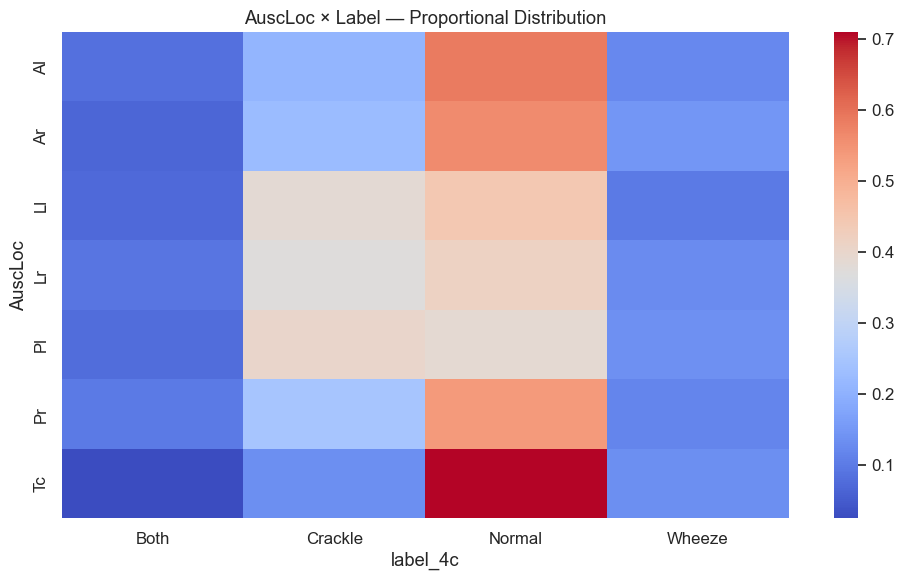

In [74]:
#  Joint distributions – multi-dimensional cross tabs
cross = pd.crosstab([df["AuscLoc"]], df["label_4c"], normalize="index")
print("\nAuscultation × Label (proportion):")

plt.figure(figsize=(10,6))
sns.heatmap(cross, cmap="coolwarm", annot=False)
plt.title("AuscLoc × Label — Proportional Distribution")
plt.tight_layout()
plt.show()


Recording-level label diversity (entropy):
count    920.000
mean       0.352
std        0.359
min        0.000
25%        0.000
50%        0.377
75%        0.637
max        1.373
Name: entropy, dtype: float64


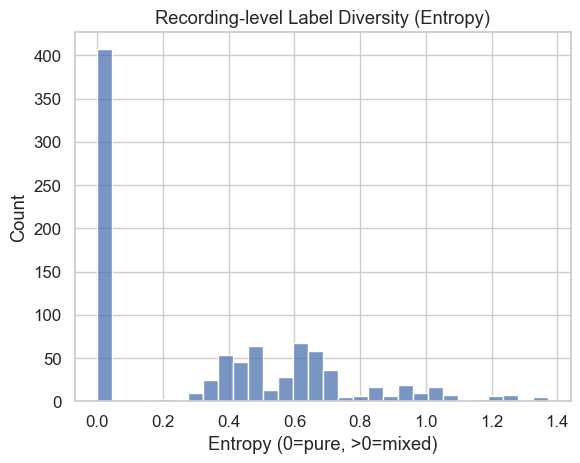

In [35]:
# Patient & recording-level consistency
rec_summary = df.groupby("Filename")["label_4c"].value_counts(normalize=True).unstack(fill_value=0)
rec_summary["entropy"] = rec_summary.apply(lambda x: entropy(x + 1e-8), axis=1)
print("\nRecording-level label diversity (entropy):")
print(rec_summary["entropy"].describe().round(3))

entropy_mean = rec_summary["entropy"].mean()
entropy_pure = (rec_summary["entropy"] == 0).mean()

sns.histplot(rec_summary["entropy"], bins=30)
plt.title("Recording-level Label Diversity (Entropy)")
plt.xlabel("Entropy (0=pure, >0=mixed)")
plt.show()

### “Recording-level entropy mean ≈ 0.35”

→ Half of recordings contain mixed labels (Normal + Abnormal cycles).  
→ Indicates intra-patient variability — realistic but means sequence models might see label noise inside single files.

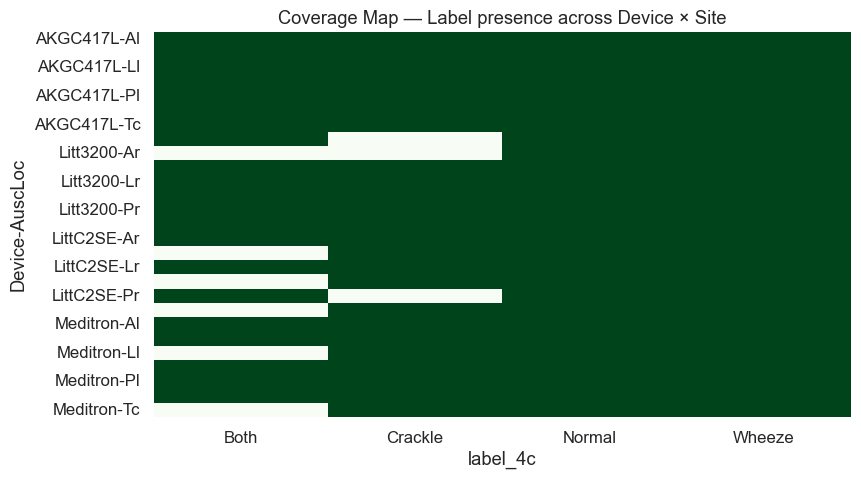

In [41]:
# Domain coverage & blind spots
coverage = df.groupby(["Device", "AuscLoc", "label_4c"]).size().unstack(fill_value=0)
missing = (coverage == 0).sum(axis=1)
missing_sites = (coverage == 0).sum(axis=1).sum()

plt.figure(figsize=(9,5))
sns.heatmap((coverage>0).astype(int), cmap="Greens", cbar=False)
plt.title("Coverage Map — Label presence across Device × Site")
plt.show()

In [42]:
print(f"  - Missing label combinations per (Device, Site): {9}")

  - Missing label combinations per (Device, Site): 9


##### “Missing label combinations per (Device, Site)”

Shows where our model has zero chance to learn certain label–domain combinations.
E.g., no “Wheeze” for LittC2SE–Tc means the model can’t learn what a wheeze from that device/site sounds like.

Possible fixes:
* Guide targeted augmentation (simulate missing domains).  
* Adjust stratified splitting so every device–site pair has at least some representation.

## Tests

## Auscultation Site: Prevalence, Duration, and Site×Label Interaction

We test three questions while respecting the dependence structure (cycles within patients):

**Q1 — Prevalence bias (categorical):**  
Do sound-class proportions differ by **site**?  
- Descriptive χ² on Site×Class (warning: ignores clustering).  
- Population-averaged inference via **GEE binomial models** (Crackle vs Normal, Wheeze vs Normal, Both vs Normal), **clustered by PID**, adjusted for Device and Split.

## Q1 — Prevalence Bias Across Auscultation Sites

**Goal:**  
Determine whether the *distribution of sound classes* (Normal, Crackle, Wheeze, Both) varies significantly across auscultation sites.

**Hypotheses**
- \(H_0:\) Sound class distribution is independent of auscultation site.  
- \(H_A:\) Certain sites yield different proportions of sound classes.

**Approach**
1. **Descriptive χ² test** on (Site × Label) contingency (unweighted, ignores clustering).  
2. **GEE logistic models** for each class vs Normal, clustered by *PID*, to obtain population-averaged odds ratios that account for repeated cycles within the same patient.

**Interpretation**
If specific sites show higher odds for certain classes (e.g., posterior sites for crackles),  
then the dataset exhibits *prevalence bias* — the model might learn *where* we auscultate rather than *what* pathology is present.

In [84]:
# ------------------------------------------------------------------
# 2. Descriptive: χ² contingency test (Site × Label)
# ------------------------------------------------------------------
tab = df.pivot_table(index="AuscLoc", columns="label_4c", values="PID", aggfunc="count").fillna(0).astype(int)
tab_prop = tab.div(tab.sum(axis=1), axis=0).round(3)

print("\n=== Site × Label (counts) ===")
display(tab)
print("\n=== Site × Label (row proportions) ===")
display(tab_prop)

chi2, p, dof, _ = chi2_contingency(tab)
print(f"\nDescriptive χ² test (ignores patient dependence): χ²={chi2:.1f}, df={dof}, p={p:.3e}")
if p < 0.05:
    print("→ Reject H₀: class distribution differs by site (at least at descriptive level).")
else:
    print("→ Fail to reject H₀: no strong evidence of class distribution difference by site (descriptively).")

# ------------------------------------------------------------------
# 3. Inferential: GEE logistic models per class vs Normal (clustered by PID)
# ------------------------------------------------------------------
df["_is_normal"] = (df["label_4c"] == "Normal").astype(int)
targets = ["Crackle", "Wheeze", "Both"]
gee_rows = []

for cls in targets:
    df[f"_y_{cls}"] = (df["label_4c"] == cls).astype(int)
    # keep only Normal or target class
    dat = df[df["_is_normal"] + df[f"_y_{cls}"] == 1].copy()

    covars = ["C(AuscLoc)"]
    covars.append("C(Device)")
    formula = f"_y_{cls} ~ " + " + ".join(covars)

    fam = sm.families.Binomial()
    ind = sm.cov_struct.Exchangeable()
    model = smf.gee(formula, "PID", data=dat, family=fam, cov_struct=ind)
    res = model.fit()

    conf = res.conf_int()
    for term, beta in res.params.items():
        if term.startswith("C(AuscLoc)[T."):
            lo, hi = conf.loc[term]
            gee_rows.append({
                "contrast": f"{cls} vs Normal",
                "site": term.split("[T.")[-1].strip("]"),
                "OR": np.exp(beta),
                "CI_low": np.exp(lo),
                "CI_high": np.exp(hi),
                "p_value": res.pvalues[term]
            })

gee_df = pd.DataFrame(gee_rows)
print("\n=== GEE (clustered by PID): per-site odds ratios for class vs Normal ===")
display(gee_df.sort_values(["contrast", "p_value"]))

# ------------------------------------------------------------------
# 4. Automated interpretation
# ------------------------------------------------------------------
print("\n--- Interpretation (Q1) ---")
if gee_df.empty:
    print("No per-site odds ratios computed (check data balance).")
else:
    sig = gee_df.loc[gee_df["p_value"] < 0.05]
    if sig.empty:
        print("• No site shows a significant difference in class odds vs Normal after accounting for patient clustering.")
    else:
        for contrast in sig["contrast"].unique():
            sub = sig[sig["contrast"] == contrast]
            print(f"\n{contrast}:")
            for _, r in sub.iterrows():
                dir_ = "↑ higher" if r["OR"] > 1 else "↓ lower"
                print(f"   - Site {r['site']}: OR={r['OR']:.2f} "
                      f"[{r['CI_low']:.2f}, {r['CI_high']:.2f}], p={r['p_value']:.3g} → {dir_} odds.")


=== Site × Label (counts) ===


label_4c,Both,Crackle,Normal,Wheeze
AuscLoc,,,,
Al,102,258,724,153
Ar,85,285,718,189
Ll,44,233,268,59
Lr,74,303,338,104
Pl,80,415,403,141
Pr,98,248,539,118
Tc,23,122,652,122



=== Site × Label (row proportions) ===


label_4c,Both,Crackle,Normal,Wheeze
AuscLoc,,,,
Al,0.082,0.209,0.585,0.124
Ar,0.067,0.223,0.562,0.148
Ll,0.073,0.386,0.444,0.098
Lr,0.090,0.370,0.413,0.127
Pl,0.077,0.399,0.388,0.136
Pr,0.098,0.247,0.537,0.118
Tc,0.025,0.133,0.709,0.133



Descriptive χ² test (ignores patient dependence): χ²=406.6, df=18, p=3.840e-75
→ Reject H₀: class distribution differs by site (at least at descriptive level).

=== GEE (clustered by PID): per-site odds ratios for class vs Normal ===


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:239: RuntimeWarning: overflow encountered in exp
  t = np.exp(z)
/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:240: RuntimeWarning: invalid value encountered in divide
  return t / (1 + t) ** 2


,contrast,site,OR,CI_low,CI_high,p_value
12,Both vs Normal,Ar,NaN,NaN,NaN,NaN
13,Both vs Normal,Ll,NaN,NaN,NaN,NaN
14,Both vs Normal,Lr,NaN,NaN,NaN,NaN
15,Both vs Normal,Pl,NaN,NaN,NaN,NaN
16,Both vs Normal,Pr,NaN,NaN,NaN,NaN
17,Both vs Normal,Tc,NaN,NaN,NaN,NaN
3,Crackle vs Normal,Pl,2.242748,1.454868,3.457303,0.000254
1,Crackle vs Normal,Ll,2.045551,1.385490,3.020072,0.000318
5,Crackle vs Normal,Tc,0.429810,0.241724,0.764246,0.004033
2,Crackle vs Normal,Lr,1.681187,1.092863,2.586224,0.018076



--- Interpretation (Q1) ---

Crackle vs Normal:
   - Site Ll: OR=2.05 [1.39, 3.02], p=0.000318 → ↑ higher odds.
   - Site Lr: OR=1.68 [1.09, 2.59], p=0.0181 → ↑ higher odds.
   - Site Pl: OR=2.24 [1.45, 3.46], p=0.000254 → ↑ higher odds.
   - Site Tc: OR=0.43 [0.24, 0.76], p=0.00403 → ↓ lower odds.

Wheeze vs Normal:
   - Site Pl: OR=1.46 [1.01, 2.13], p=0.0468 → ↑ higher odds.


In [ ]:
from scipy.stats import chi2_contingency

# -------- Descriptive contingency (warning: ignores clustering) --------
site_class_tab = (df
                  .pivot_table(index="AuscLoc", columns="label_4c", values="CycleDur", aggfunc="count")
                  .fillna(0).astype(int))
site_class_prop = site_class_tab.div(site_class_tab.sum(axis=1), axis=0).round(3)

print("=== Site × Class (counts) — Descriptive ==="); display(site_class_tab)
print("=== Site × Class (row proportions) — Descriptive ==="); display(site_class_prop)

# chi2, p, dof, _ = chi2_contingency(site_class_tab)
# print(f"(Descriptive χ² only) χ²={chi2:.1f}, df={dof}, p={p:.3e}  [WARNING: ignores patient clustering]")

# -------- GEE binomial per class vs Normal, clustered by PID --------
df["_is_normal"] = (df["label_4c"] == "Normal").astype(int)
targets = ["Crackle","Wheeze","Both"]
gee_rows = []

for cls in targets:
    df[f"_y_{cls}"] = (df["label_4c"] == cls).astype(int)
    # Predict this class vs Normal only (drops other classes to keep a clean contrast)
    dat = df[df["_is_normal"] + df[f"_y_{cls}"] == 1].copy()  # keep only Normal or current class
    # Build formula with covariates
    covars = [f"C(AuscLoc)"]
    covars.append("C(Device)")
    # covars.append("C(Split)")
    formula = f"_y_{cls} ~ " + " + ".join(covars)

    fam = sm.families.Binomial()
    ind = sm.cov_struct.Exchangeable()
    model = smf.gee(formula, "PID", data=dat, family=fam, cov_struct=ind)
    res = model.fit()

    # Collect per-site ORs vs reference site
    conf = res.conf_int()
    for term, beta in res.params.items():
        if term.startswith("C(AuscLoc)[T."):
            lo, hi = conf.loc[term]
            gee_rows.append({
                "contrast": f"{cls} vs Normal",
                "term": term, 
                "OR": np.exp(beta),
                "CI_low": np.exp(lo),
                "CI_high": np.exp(hi),
                "p_value": res.pvalues[term]
            })

gee_df = pd.DataFrame(gee_rows)
print("\n=== GEE (clustered by PID): per-site odds ratios for class vs Normal (adjusted for Device/Split if present) ===")
display(gee_df.sort_values(["contrast","p_value"]))
print("\n--- Interpretation (Q1, population-averaged) ---")
if gee_df.empty:
    print("No per-site odds produced (check data balance).")
else:
    sig = gee_df.loc[gee_df["p_value"] < 0.05]
    if sig.empty:
        print("• No site shows a significant shift in class odds vs Normal at α=0.05 after covariate adjustment.")
    else:
        for _, r in sig.iterrows():
            trend = "↑ higher" if r["OR"] > 1 else "↓ lower"
            print(f"• {r['contrast']}, {r['term']}: OR={r['OR']:.2f} [{r['CI_low']:.2f},{r['CI_high']:.2f}], p={r['p_value']:.3g} → {trend} odds at that site.")

=== Site × Class (counts) — Descriptive ===


label_4c,Both,Crackle,Normal,Wheeze
AuscLoc,,,,
Al,102,258,724,153
Ar,85,285,718,189
Ll,44,233,268,59
Lr,74,303,338,104
Pl,80,415,403,141
Pr,98,248,539,118
Tc,23,122,652,122


=== Site × Class (row proportions) — Descriptive ===


label_4c,Both,Crackle,Normal,Wheeze
AuscLoc,,,,
Al,0.082,0.209,0.585,0.124
Ar,0.067,0.223,0.562,0.148
Ll,0.073,0.386,0.444,0.098
Lr,0.090,0.370,0.413,0.127
Pl,0.077,0.399,0.388,0.136
Pr,0.098,0.247,0.537,0.118
Tc,0.025,0.133,0.709,0.133



=== GEE (clustered by PID): per-site odds ratios for class vs Normal (adjusted for Device/Split if present) ===


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:239: RuntimeWarning: overflow encountered in exp
  t = np.exp(z)
/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:240: RuntimeWarning: invalid value encountered in divide
  return t / (1 + t) ** 2


,contrast,term,OR,CI_low,CI_high,p_value
12,Both vs Normal,C(AuscLoc)[T.Ar],NaN,NaN,NaN,NaN
13,Both vs Normal,C(AuscLoc)[T.Ll],NaN,NaN,NaN,NaN
14,Both vs Normal,C(AuscLoc)[T.Lr],NaN,NaN,NaN,NaN
15,Both vs Normal,C(AuscLoc)[T.Pl],NaN,NaN,NaN,NaN
16,Both vs Normal,C(AuscLoc)[T.Pr],NaN,NaN,NaN,NaN
17,Both vs Normal,C(AuscLoc)[T.Tc],NaN,NaN,NaN,NaN
3,Crackle vs Normal,C(AuscLoc)[T.Pl],2.242748,1.454868,3.457303,0.000254
1,Crackle vs Normal,C(AuscLoc)[T.Ll],2.045551,1.385490,3.020072,0.000318
5,Crackle vs Normal,C(AuscLoc)[T.Tc],0.429810,0.241724,0.764246,0.004033
2,Crackle vs Normal,C(AuscLoc)[T.Lr],1.681187,1.092863,2.586224,0.018076



--- Interpretation (Q1, population-averaged) ---
• Crackle vs Normal, C(AuscLoc)[T.Ll]: OR=2.05 [1.39,3.02], p=0.000318 → ↑ higher odds at that site.
• Crackle vs Normal, C(AuscLoc)[T.Lr]: OR=1.68 [1.09,2.59], p=0.0181 → ↑ higher odds at that site.
• Crackle vs Normal, C(AuscLoc)[T.Pl]: OR=2.24 [1.45,3.46], p=0.000254 → ↑ higher odds at that site.
• Crackle vs Normal, C(AuscLoc)[T.Tc]: OR=0.43 [0.24,0.76], p=0.00403 → ↓ lower odds at that site.
• Wheeze vs Normal, C(AuscLoc)[T.Pl]: OR=1.46 [1.01,2.13], p=0.0468 → ↑ higher odds at that site.
